In [1]:
from osgeo import gdal
from osgeo import ogr, osr
import numpy as np
import s3fs
import os
import os.path
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Adjust the variable inputs to create the prefix for the file of interest
bucket_name = 'noaa-goes16' # Change to 'noaa-goes17' for GOES-17 satellite
product_name = 'ABI-L2-ACMC'# Choose a GOES-R L2+ product with a binary variable, 
                            # ie. Clear Sky Mask (ACMC/ACMF) or Aersol Detection (ADPC/ADPF)
year = 2021 
day_of_year = 1 
hour = 16

# Adjust pathname to local directory
directory = "/Users/daniellelosos/GOESforGIS/"

In [3]:
# Make new directories to store files
if not os.path.isdir(directory + product_name +"_netCDFs"):
    os.mkdir(directory + product_name +"_netCDFs")
if not os.path.isdir(directory + product_name +"_shapefiles"):
    os.mkdir(directory + product_name +"_shapefiles") 

In [4]:
# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Use anonymous credentials to access public data  from AWS
fs = s3fs.S3FileSystem(anon=True)

# Write prefix for the files of interest, and list all files beginning with this prefix.
prefix = f'{bucket_name}/{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/'
print(prefix)
files = fs.ls(prefix)

noaa-goes16/ABI-L2-ACMC/2021/001/16/


In [5]:
#Read the first netCDF file in the list (closest to the top of the hour) and download
first_file = files[0]
path = directory + product_name +"_netCDFs/" + first_file.split("/")[-1]
fs.download(first_file, path)

[None]

In [6]:
f = netCDF4.Dataset(path)

# Choose the first variable/subdataset in the netCDF file to convert to a GeoTIFF.
# To select altnative variable stored in the file, adjust the list number, ie. [0] selects the 1st variable 
var = list(f.variables.keys())[0] 
print ("Selected variable: " + var)

# Uncomment the line below to reveal the list of variables stored in the file
#print(list(f.variables.keys()))

Selected variable: BCM


In [7]:
# Open dataset and parse variable information
ds = xr.open_dataset(path)
var_name = ds[var].long_name
variable = ds[var].data

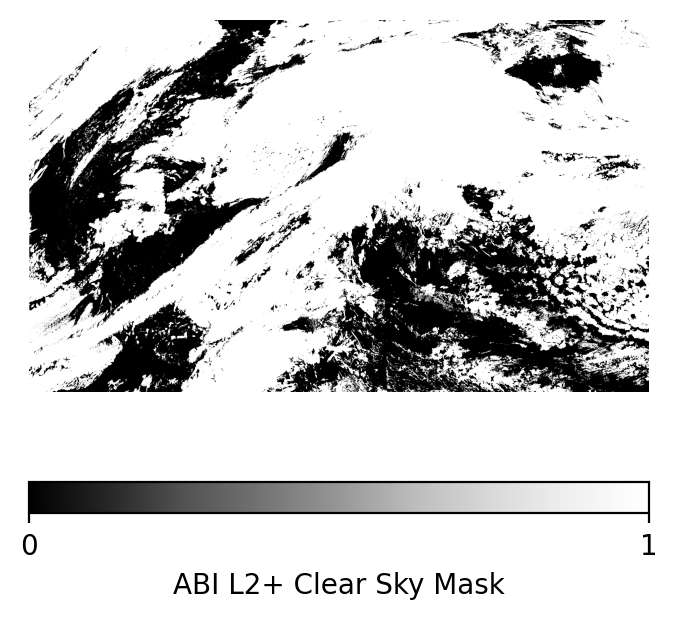

In [8]:
# Plot the variable to check if data loaded correctly
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(variable, cmap='Greys_r')
cb = fig.colorbar(im, ticks=[0, 1], orientation='horizontal')
cb.set_label(var_name)
plt.axis('off')
plt.show()

In [9]:
# Open netCDF file with rasterio
netCDF_file = xr.open_rasterio('netcdf:{0}:{1}'.format(path, var))

# Parse GOES-R geostationary coordinate reference system (crs)
goesR_crs = netCDF_file.crs
Projection = osr.SpatialReference()
Projection.ImportFromProj4(goesR_crs)
goesR_crs

'+proj=geos +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs=True'

In [10]:
# Use gdal to open the selected variable's raster band
layer = gdal.Open("NETCDF:{0}:{1}".format(path, var))
band = layer.GetRasterBand(1)

# Create an output shapfile with a layer containing a new field
drv = ogr.GetDriverByName('ESRI Shapefile')
shp_name = directory + product_name + "_shapefiles/" + var 
outfile = drv.CreateDataSource(shp_name + ".shp") 
outlayer = outfile.CreateLayer('polygonized raster', srs = Projection)
newField = ogr.FieldDefn(product_name, ogr.OFTReal)
outlayer.CreateField(newField)

# Use gdal.polygonize to convert the raster band into a polygons and store binary values of each polygon in new field
gdal.Polygonize(band, None, outlayer, 0, [])
outfile = None
print(shp_name + " has been generated")

/Users/daniellelosos/GOESforGIS/ABI-L2-ACMC_shapefiles/BCM has been generated
